In [99]:
import numpy as np
import matplotlib.pyplot as plt
from hamming_distance_distribution import hamming_distance
from annealing import is_connected, adjacency_from_couplings, degree_of_nodes

In [100]:
def get_bin_edges(binsize, min, max):
    """returns the bin edges for a histogram such that the leftmost bin is centered around min"""
    bin_edges = [min-binsize/2]
    while bin_edges[-1] < max:
        bin_edges.append(bin_edges[-1]+binsize)
    return np.array(bin_edges)


def get_bin_index(bin_edges, value):
    """finds the index of the bin in which value belongs"""
    for i in range(len(bin_edges)-1):
        if value > bin_edges[i] and value < bin_edges[i+1]:
            return i
        
    print(f"Could not find bin for value {value}. Check bin range: min: {bin_edges[0]}, max: {bin_edges[-1]}.")
    return None


def annealing_by_degree(fname, blocksize, avg_binsize=0.25):
    data = np.load(fname, allow_pickle=True).item()
    N = data["N"]
    size = data["size"]

    bin_edges = get_bin_edges(1, 0, N-1)                 # if there are N users, the maximum possible degree is N-1
    bin_avg_edges = get_bin_edges(avg_binsize, 0, N-1)

    N_blocks = int(data['size']/blocksize)

    N_bin_avg_correct   = np.zeros(shape=(N_blocks, len(bin_avg_edges)-1))
    N_bin_avg           = np.zeros(shape=(N_blocks, len(bin_avg_edges)-1))

    N_bin_max_correct = np.zeros(shape=(N_blocks, len(bin_edges)-1))
    N_bin_max         = np.zeros(shape=(N_blocks, len(bin_edges)-1)) 

    N_bin_min_correct = np.zeros(shape=(N_blocks, len(bin_edges)-1))
    N_bin_min         = np.zeros(shape=(N_blocks, len(bin_edges)-1))

    for j in range(N_blocks):
        for i in range(blocksize):
            # get degrees of nodes
            degrees = degree_of_nodes(adjacency_from_couplings(data["J_n"][j*blocksize + i]))
            degree_max = np.max(degrees)
            degree_avg = np.mean(degrees)
            degree_min = np.min(degrees)
            
            d_Hamming = hamming_distance(data["alpha"][j*blocksize + i], data["gs_array"][j*blocksize + i])

            # classify the average degree
            i_bin_avg = get_bin_index(bin_avg_edges, degree_avg)
            N_bin_avg[j, i_bin_avg] += 1
            if d_Hamming == 0:
                N_bin_avg_correct[j, i_bin_avg] += 1

            # classify the min degree
            N_bin_min[j, degree_min] += 1                   # here, the degree of the node is equal to the index of the bin since the binsize is 1
            if d_Hamming == 0:
                N_bin_min_correct[j, degree_min] += 1

            # classify the max degree
            N_bin_max[j, degree_max] += 1
            if d_Hamming == 0:
                N_bin_max_correct[j, degree_max] += 1

    return N_bin_avg_correct, N_bin_avg, N_bin_min_correct, N_bin_min, N_bin_max_correct, N_bin_max, bin_edges, bin_avg_edges





In [101]:
# ---------- Parameters for reading data file -------------
path = "./annealing_data/"

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

neglection_thres = 0.08
blocksize = 100
avg_binsize = 0.25

# Degree distribution for the selected thresold

The dataset has a size of 700
N = 5
[-0.5  0.5  1.5  2.5  3.5  4.5]


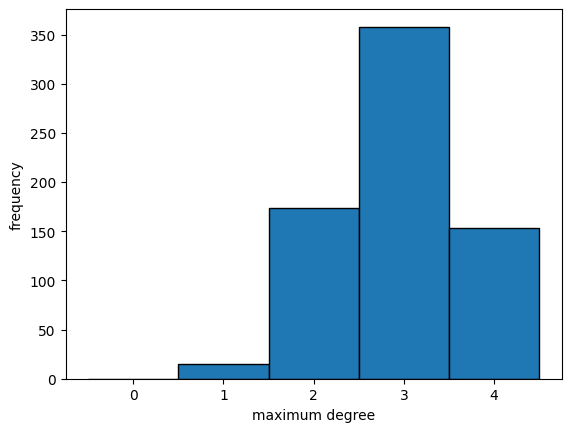

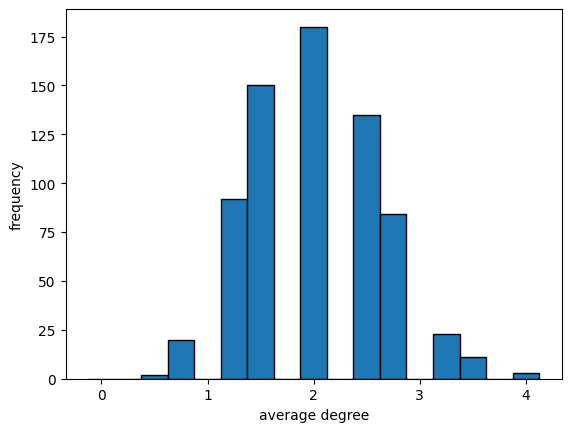

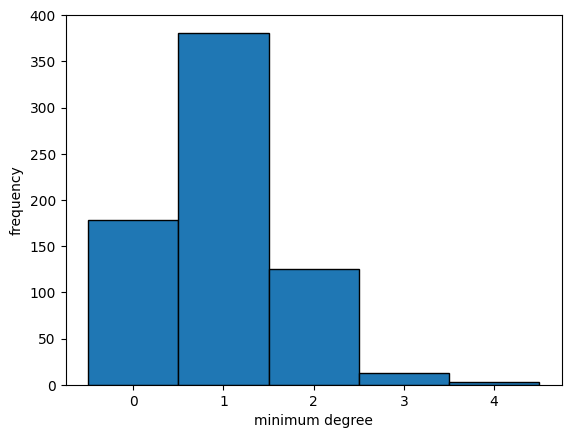

In [102]:
# ----------------- Program -----------------
# check the degree distribution of degrees for a neglection thresold
fname = path + f"neglection_thres_{neglection_thres}_N_5_M_4_K_100_xi_0.npy"
data = np.load(fname, allow_pickle=True).item()

size = data["size"]
print(f"The dataset has a size of {size}")

degree_max = np.zeros(size)
degree_avg = np.zeros(size)
degree_min = np.zeros(size)

for i in range(size):
    degrees = degree_of_nodes(adjacency_from_couplings(data["J_n"][i]))
    degree_max[i] = np.max(degrees)
    degree_min[i] = np.min(degrees)
    degree_avg[i] = np.mean(degrees)

print(f"N = {data['N']}")

bins = get_bin_edges(1, 0, data["N"]-1)
print(bins)
bins_avg = get_bin_edges(avg_binsize, 0, data["N"]-1)


plt.hist(degree_max, align="mid", bins=bins, edgecolor="black")
plt.ylabel("frequency")
plt.xlabel("maximum degree")
plt.show()

plt.hist(degree_avg, align="mid", bins=bins_avg, edgecolor="black")
plt.xlabel("average degree")
plt.ylabel("frequency")
plt.show()

plt.hist(degree_min, align="mid", bins=bins, edgecolor="black")
plt.xlabel("minimum degree")
plt.ylabel("frequency")
plt.show()

# Evolution of correct results depending on the degree

In [103]:
N_bin_avg_correct, N_bin_avg, N_bin_min_correct, N_bin_min, N_bin_max_correct, N_bin_max, bin_min_max_edges, bin_avg_edges = annealing_by_degree(fname, blocksize, avg_binsize)

In [104]:
def get_ratio_statistics(N_bin_correct, N_bin):
    """Computes the ratio N_bin_correct/N_bin. For the statistics, this function takes into consideration, that N_bin might be zero in some places.
    statistical quantities are computed excluding those places where a np.nan would be in the ratio.
    """
    # ratio of correct identifications
    r_bin_correct = N_bin_correct / N_bin           # there will be np.nan in r_bin_correct since N_bin might be zero at some places
    
    # setup arrays
    N_bins = np.shape(N_bin)[1]
    r_bin_correct_mean = np.zeros(N_bins)
    dr_bin_correct = np.zeros_like(r_bin_correct_mean)
    dr_bin_correct_mean = np.zeros_like(r_bin_correct_mean)

    # compute statistics for every column (i.e. bin) separately to take into account that there might be a different number of values in column due to np.nan in the ratios because of possible zero divisions
    for i in range(N_bins):
        where_not_div_by_0 = np.where(N_bin[:, i]!=0)
        
        if len(where_not_div_by_0[0]) == 0:
            r_bin_correct_mean[i]   = -np.inf               # set to -np.inf to signalize that there were no non-nan values in the column over which the mean would have to be computed -> later one can exclude these datapoints from the plots
            dr_bin_correct[i]       = -np.inf
            dr_bin_correct_mean[i]  = -np.inf
        
        else:
            r_bin_correct_mean[i]   = np.mean(r_bin_correct[:, i][where_not_div_by_0])
            dr_bin_correct[i]       = np.std(r_bin_correct[:, i][where_not_div_by_0])
            dr_bin_correct_mean[i]  = dr_bin_correct[i] / np.sqrt(len(where_not_div_by_0[0]))
    
    return r_bin_correct_mean, dr_bin_correct_mean



r_bin_max_correct_mean, dr_bin_max_correct_mean = get_ratio_statistics(N_bin_max_correct, N_bin_max)
r_bin_min_correct_mean, dr_bin_min_correct_mean = get_ratio_statistics(N_bin_min_correct, N_bin_min)
r_bin_avg_correct_mean, dr_bin_avg_correct_mean = get_ratio_statistics(N_bin_avg_correct, N_bin_avg)

/tmp/ipykernel_2948/3989178443.py:6: RuntimeWarning: invalid value encountered in divide
  r_bin_correct = N_bin_correct / N_bin           # there will be np.nan in r_bin_correct since N_bin might be zero at some places


In [105]:
print(r_bin_max_correct_mean)
print(dr_bin_max_correct_mean)
print(r_bin_min_correct_mean)
print(dr_bin_min_correct_mean)
print(r_bin_avg_correct_mean)
print(dr_bin_avg_correct_mean)

[      -inf 1.         0.9386141  0.89082751 0.78726624]
[      -inf 0.         0.02410787 0.01601497 0.0293674 ]
[0.89632022 0.88427378 0.87115109 0.7        0.33333333]
[0.0235648  0.01821091 0.01522592 0.20615528 0.27216553]
[      -inf       -inf 1.         1.               -inf 0.93742369
 0.90927644       -inf 0.9131398        -inf 0.84327439 0.79814233
       -inf 0.78095238 0.66666667       -inf 0.33333333]
[      -inf       -inf 0.         0.               -inf 0.02123833
 0.03432576       -inf 0.02269017       -inf 0.03255586 0.04241438
       -inf 0.08020867 0.20412415       -inf 0.27216553]


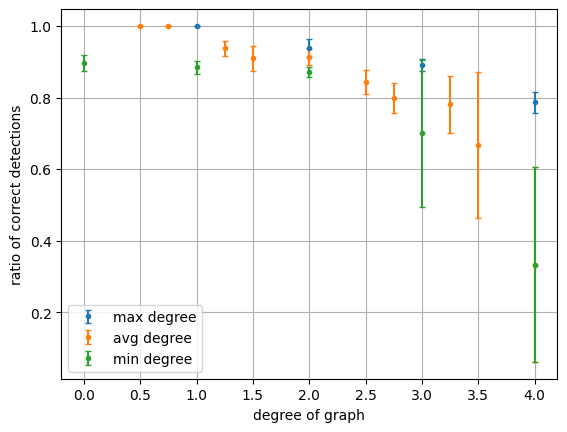

In [106]:
# ------------- plotting --------------
def plot_ratios(bin_edges, r_bin_correct_mean, dr_bin_correct_mean, label):
    x = (bin_edges[1:] + bin_edges[:-1])/2
    where_not_inf = np.where(r_bin_correct_mean != -np.inf)
    plt.errorbar(x=x[where_not_inf], y=r_bin_correct_mean[where_not_inf], yerr=dr_bin_correct_mean[where_not_inf], capsize=2, marker=".", ls="none", label=label)
    

plot_ratios(bin_min_max_edges, r_bin_max_correct_mean, dr_bin_max_correct_mean, "max degree")
plot_ratios(bin_avg_edges, r_bin_avg_correct_mean, dr_bin_avg_correct_mean, "avg degree")
plot_ratios(bin_min_max_edges, r_bin_min_correct_mean, dr_bin_min_correct_mean, "min degree")
plt.xlabel("degree of graph")
plt.ylabel("ratio of correct detections")
plt.grid()
plt.legend()
plt.show()

